## Imports

In [1]:
!pip install scikit-image
!pip install imagededup
!pip install segmentation-models

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import skimage
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import gc
import sys
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import tensorflow_hub as hub
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
#from models.model_factory import get_model


#from imagededup.methods import PHash

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Segmentation Models: using `tf.keras` framework.


## Config

In [6]:
labelled_frame=4 #for this dataset
train_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
test_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'
val_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'

input_dir = '/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset'
dtype = tf.float16

DATA_AUG = False
RANDOM_RESIZE_AND_CROP = False
INPUT_SHAPE = (256, 256, 3)
OUTPUT_SHAPE = (256, 256, 3)

model_path = 'path to model'

## EDA

(-0.5, 255.5, 255.5, -0.5)

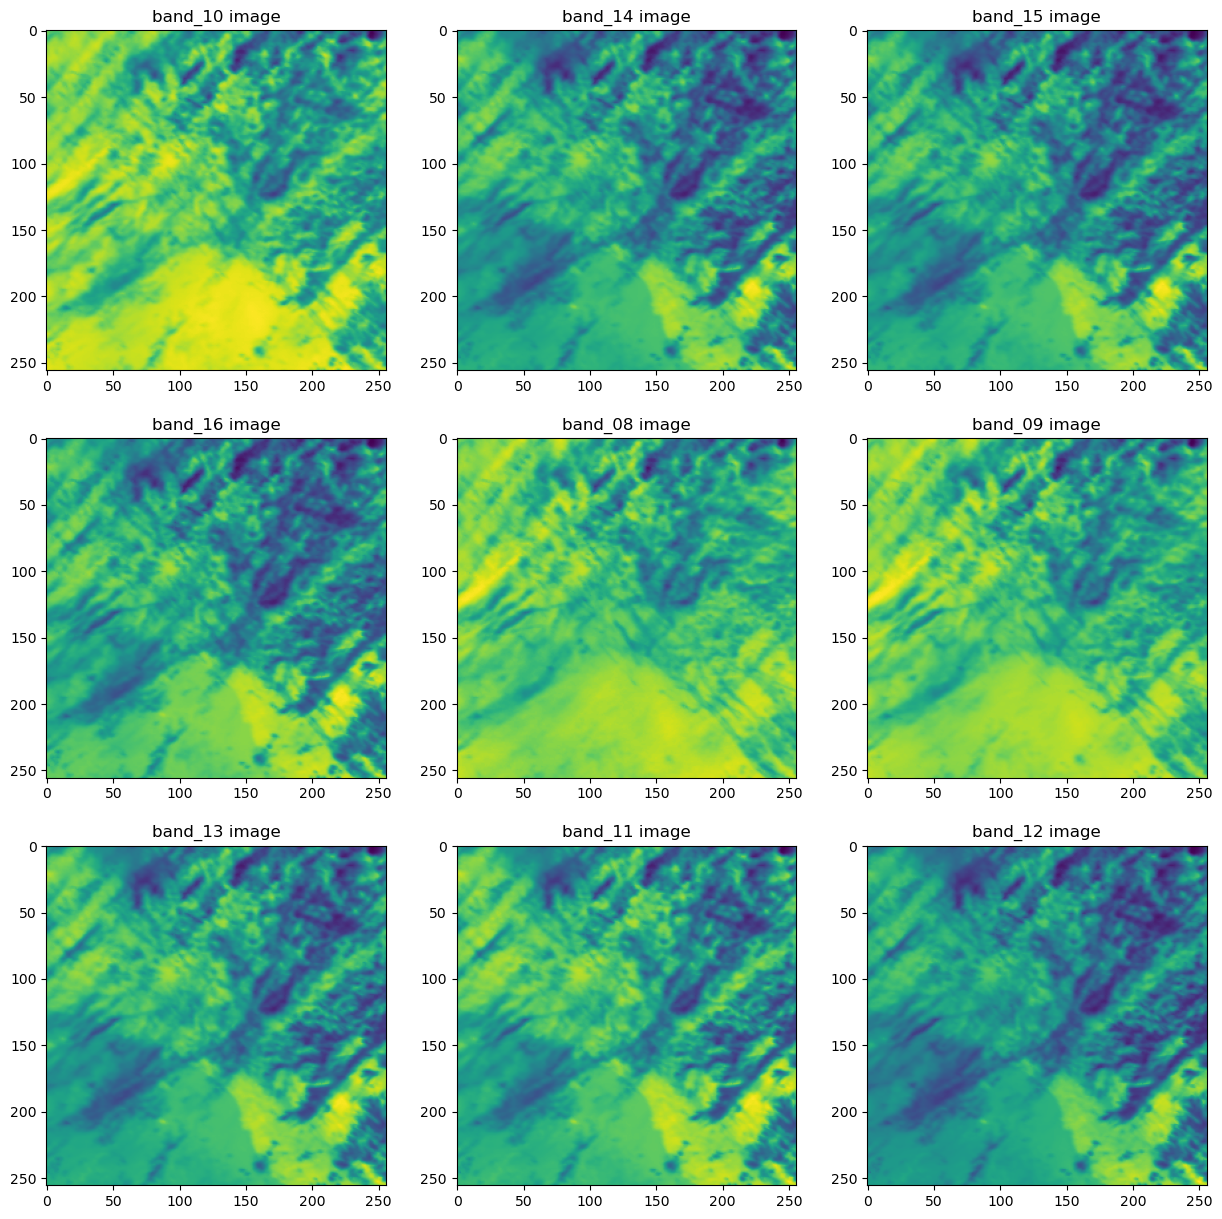

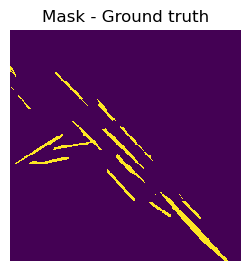

In [7]:
record_id = '10016536018877742'

#band_n=np.load(os.path.join(train_dir, record_id, 'band_09.npy'))
pmask=np.load(os.path.join(train_dir, record_id, 'human_pixel_masks.npy'))

#plot a sample
img={}
i=0
plt.figure(figsize=(15,15))
for dirname,_,bands in os.walk(os.path.join(train_dir, record_id)):
    for band in bands:
        if band!='human_individual_masks.npy' and band!='human_pixel_masks.npy':
            b = band.rstrip(".npy")
            img[b]=tf.constant(np.load(os.path.join(train_dir, record_id, band)),dtype=dtype)
            i+=1
            ax=plt.subplot(3,3,i)
            ax.imshow(img[b][...,labelled_frame])
            ax.set_title(f"{b} image")

plt.figure(figsize=(3,3))
plt.imshow(pmask, interpolation='none')
plt.title("Mask - Ground truth")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

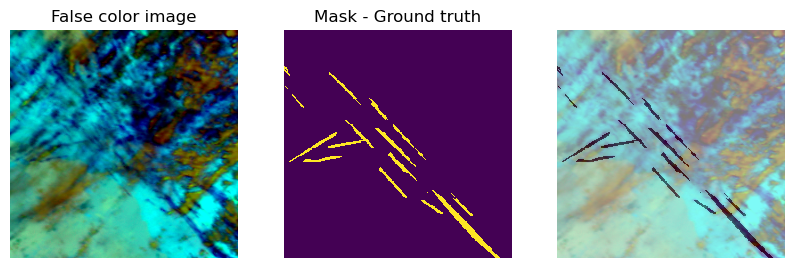

In [10]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def ash(img):
    #Takes in multiple bands and returns an ash schemed image
    r = normalize_range(img['band_15'] - img['band_14'], _TDIFF_BOUNDS)
    g = normalize_range(img['band_14'] - img['band_11'], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(img['band_14'], _T11_BOUNDS)
    false_color = tf.clip_by_value(tf.stack([r, g, b], axis=2), 0, 1)
    #return tf.cast(false_color, dtype=dtype)
    return false_color

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(tf.cast(ash(img)[..., labelled_frame], dtype=tf.float32))
plt.title("False color image")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(pmask, interpolation='none')
plt.title("Mask - Ground truth")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(tf.cast(ash(img)[..., labelled_frame], dtype=tf.float32))
plt.imshow(pmask, cmap='Reds', alpha=.5,interpolation='none')
plt.axis('off')

## Preprocessing

In [11]:
def create_dataset(path):
    #X=[]
    #y=[]
    X_filenames = []
    y_filenames = []
    for dirname,_,bands in tqdm(os.walk(os.path.join(path)),total = len(os.listdir(path))):
        img={}
        if dirname!=path:
            for band in [
        "band_11.npy", 
        "band_14.npy", 
        "band_15.npy"]:
                if band!='human_pixel_masks.npy':
                    b = band.rstrip(".npy")
                    img[b]=np.load(os.path.join(dirname, band))
            X_temp = ash(img)[..., labelled_frame]
            y_temp = np.load(os.path.join(dirname, 'human_pixel_masks.npy'))
            record_id = dirname.lstrip(path)
            dataset = path.split('/')[-1]
            os.makedirs(os.path.join(f"/kaggle/working/{dataset}", record_id),exist_ok=True)
            X_filename = os.path.join(f"/kaggle/working/{dataset}", record_id, "X.npy")
            y_filename = os.path.join(f"/kaggle/working/{dataset}", record_id, "y.npy")
            np.save(X_filename, X_temp)
            np.save(y_filename, y_temp)
            X_filenames.append(X_filename)
            y_filenames.append(y_filename)
            del img, X_temp, y_temp

In [ ]:
# def create_dataset_gen(path, BATCH_SIZE):
#     TOTAL_LEN = len(os.listdir(path))
#     ITER = TOTAL_LEN//BATCH_SIZE
#     START = END = 0

#     for i in range(ITER+1):
#         gc.collect()
#         START = END
#         END = START+BATCH_SIZE if START+BATCH_SIZE<TOTAL_LEN else TOTAL_LEN
#         if START!=END:
#             records = os.listdir(path)[START:END]

#             X=[]
#             y=[]
#             for r in records:
#                 img={}
#                 for band in ["band_11.npy", "band_14.npy", "band_15.npy"]:
#                     b = band.rstrip(".npy")
#                     img[b]=np.load(os.path.join(path,r,band))
#                 X_temp = ash(img)[..., labelled_frame]
#                 y_temp = tf.constant(np.load(os.path.join(path,r, 'human_pixel_masks.npy')))
#                 dataset = path.split('/')[-1]

#                 X.append(X_temp)
#                 y.append(y_temp)

#             X = tf.convert_to_tensor(X)
#             y = tf.convert_to_tensor(y)
#             #print(X.shape, y.shape)
#             yield tf.cast(X, dtype=tf.float16), tf.cast(y, dtype=tf.float16)

In [ ]:
        # Hard spatial augmentations
#         X_batch = tf.image.random_flip_left_right(X_batch, seed=seed)
#         y_batch = tf.image.random_flip_left_right(y_batch, seed=seed)
        
#         X_batch = tf.image.random_flip_up_down(X_batch, seed=seed)
#         y_batch = tf.image.random_flip_up_down(y_batch, seed=seed)
        #X_batch = tf.image.rot90(X_batch, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Hard color augmentations
        #X_batch = tf.image.random_brightness(X_batch, max_delta=0.2)
        #X_batch = tf.image.random_contrast(X_batch, lower=0.8, upper=1.2)
        
        # Randomly scale the image between 2.0 and 4.0 (inclusive)
#         scale_factor = tf.random.uniform(shape=[], minval=2.0, maxval=4.0, seed=seed)
#         new_height = tf.cast(tf.round(256 * scale_factor), tf.int32)
#         new_width = tf.cast(tf.round(256 * scale_factor), tf.int32)
#         X_batch = tf.image.resize(X_batch, [new_height, new_width])
#         #y_batch = tf.image.resize(y_batch, [new_height, new_width])

#         # Randomly crop the scaled image to size 512x512
#         cropped_size = (512, 512)
#         offset_height = tf.random.uniform(shape=[], minval=0, maxval=new_height - cropped_size[0] + 1, dtype=tf.int32, seed=seed)
#         offset_width = tf.random.uniform(shape=[], minval=0, maxval=new_width - cropped_size[1] + 1, dtype=tf.int32, seed=seed)
#         X_batch = tf.image.crop_to_bounding_box(X_batch, offset_height, offset_width, cropped_size[0], cropped_size[1])
        #y_batch = tf.image.crop_to_bounding_box(y_batch, offset_height, offset_width, cropped_size[0], cropped_size[1])

In [12]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size
        self.file_list = os.listdir(path)
        self.total_len = len(self.file_list)
#         self.augment = augment
#         self.seed = seed

    def __len__(self):
        return (self.total_len + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_file_list = self.file_list[idx * self.batch_size : (idx + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for r in batch_file_list:
            X_temp = tf.constant(np.load(os.path.join(self.path, r, 'X.npy')))
            y_temp = tf.constant(np.load(os.path.join(self.path, r, 'y.npy')))
            X_batch.append(X_temp)
            y_batch.append(y_temp)
        
#         if self.augment and np.random.rand() < 0.5:  # Randomly apply augmentation with 50% probability
            #X_temp_augmented, y_temp_augmented = self.apply_augmentation(X_temp, y_temp, self.seed)
#             X_batch.append(X_temp_augmented)
#             y_batch.append(y_temp_augmented)
        
        X_batch = tf.convert_to_tensor(X_batch)
        y_batch = tf.convert_to_tensor(y_batch)
        
        return tf.cast(X_batch, dtype=dtype), tf.cast(y_batch, dtype=dtype)

#     def apply_augmentation(self, X_batch, y_batch,seed=7):
#         # Convert images to tensors
#         X_batch = tf.convert_to_tensor(X_batch)
#         y_batch = tf.convert_to_tensor(y_batch)
 
#         X_batch = tf.image.resize(X_batch, [512, 512])
#         y_batch = tf.image.resize(y_batch, [512, 512])
#         return X_batch, y_batch


In [ ]:
# class ValDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, path, batch_size, augment=False, seed = 7):
#         self.path = path
#         self.batch_size = batch_size
#         self.file_list = os.listdir(path)
#         self.total_len = len(self.file_list)
#         self.augment = augment
#         self.seed = seed

#     def __len__(self):
#         return (self.total_len + self.batch_size - 1) // self.batch_size

#     def __getitem__(self, idx):
#         batch_file_list = self.file_list[idx * self.batch_size : (idx + 1) * self.batch_size]
#         X_batch = []
#         y_batch = []
#         for r in batch_file_list:
#             X_temp = tf.constant(np.load(os.path.join(self.path, r, 'X.npy')))
#             y_temp = tf.constant(np.load(os.path.join(self.path, r, 'y.npy')))
        
# #         if self.augment:
#             #X_temp_augmented, y_temp_augmented = self.apply_augmentation(X_temp, y_temp, self.seed)
#             X_batch.append(X_temp)
#             y_batch.append(y_temp)
        
#         X_batch = tf.convert_to_tensor(X_batch)
#         y_batch = tf.convert_to_tensor(y_batch)

#         return tf.cast(X_batch, dtype=dtype), tf.cast(y_batch, dtype=dtype)

#     def apply_augmentation(self, X_batch, y_batch,seed=7):
#         # Convert images to tensors
#         X_batch = tf.convert_to_tensor(X_batch)
#         y_batch = tf.convert_to_tensor(y_batch)
 
       
#         X_batch = tf.image.resize(X_batch, [512, 512])
#         y_batch = tf.image.resize(y_batch, [512, 512])
#         return X_batch, y_batch


In [ ]:
# def create_dataset(records, path):
#     X_filenames = []
#     y_filenames = []

#     X=[]
#     y=[]
#     for r in tqdm(records,total = len(records)):
#         img={}
#         for band in ["band_11.npy", "band_14.npy", "band_15.npy"]:
#             b = band.rstrip(".npy")
#             img[b]=np.load(os.path.join(path,r,band))
#         X_temp = ash(img)[..., labelled_frame]
#         y_temp = tf.constant(np.load(os.path.join(path,r, 'human_pixel_masks.npy')))
#         dataset = path.split('/')[-1]
# #         os.makedirs(os.path.join(f"/kaggle/working/{dataset}", r),exist_ok=True)
# #         X_filename = os.path.join(f"/kaggle/working/{dataset}", r, "X.npy")
# #         y_filename = os.path.join(f"/kaggle/working/{dataset}", r, "y.npy")
# #         np.save(X_filename, X_temp)
# #         np.save(y_filename, y_temp)
# #         X_filenames.append(X_filename)
# #         y_filenames.append(y_filename)
# #         del img, X_temp, y_temp
# #         gc.collect()
#         X.append(X_temp)
#         y.append(y_temp)

# #     X = tf.stack([tf.constant(np.load(filename), dtype=tf.float16) for filename in X_filenames], axis=0)
# #     y = tf.stack([tf.constant(np.load(filename), dtype=tf.float16) for filename in y_filenames], axis=0)
# #     [os.remove(filename) for filename in X_filenames]
# #     [os.remove(filename) for filename in y_filenames]
#     #print(X[0].shape)
#     X = tf.convert_to_tensor(X)
#     y = tf.convert_to_tensor(y)
#     #print(X.shape, y.shape)
#     return tf.cast(X, dtype=tf.float16), tf.cast(y, dtype=tf.float16)

In [ ]:
# create_dataset(train_dir)
# create_dataset(val_dir)


In [ ]:
# X_train=[]
# y_train=[]

# for record in os.listdir(train_dir):
#     X_filename =  f'X_{record}.npy' 
#     X_train.append(np.load(X_filename))
#     os.remove(X_filename)
    
#     y_filename =  f'y_{record}.npy' 
#     y_train.append(np.load(y_filename))
#     os.remove(y_filename)

# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)

In [ ]:
# def get_Xy(ds='train'):
#     X_filenames = []
#     y_filenames = []
#     for dirname,_,files in tqdm(os.walk(os.path.join(input_dir,ds))):
#         if dirname!=os.path.join(input_dir,ds):
#             X_filenames.append(os.path.join(dirname,files[1]))
#             y_filenames.append(os.path.join(dirname,files[0]))
#     with tf.device('/cpu:0'):
#         X = tf.stack([tf.constant(np.load(filename), dtype=tf.float16) for filename in X_filenames], axis=0)
#         y = tf.stack([tf.constant(np.load(filename), dtype=tf.float16) for filename in y_filenames], axis=0)
#     return tf.cast(X, dtype=tf.float16), tf.cast(y, dtype=tf.float16)

# X_train, y_train = get_Xy('train')
# X_val, y_val = get_Xy('validation')

# X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
# X_train = tf.constant(np.load('/kaggle/input/icrgw-compact-single-frame-labelled-ash-color/X_train.npy'))
# y_train = tf.constant(np.load('/kaggle/input/icrgw-compact-single-frame-labelled-ash-color/y_train.npy'))

# X_val = tf.constant(np.load('/kaggle/input/icrgw-compact-single-frame-labelled-ash-color/X_val.npy'))
# y_val = tf.constant(np.load('/kaggle/input/icrgw-compact-single-frame-labelled-ash-color/y_val.npy'))

### Removing duplicates

In [ ]:

# def npy_to_png(path):
    
#     dataset = path.split('/')[-1]
    
#     if not os.path.exists(f'{dataset}_with_unique_img'):
#         os.mkdir(f'{dataset}_with_unique_img')
#     records = os.listdir(path)
#     for r in tqdm(records):
#         img = np.load(os.path.join(path,r,'X.npy'))
#         plt.imsave(os.path.join(f'{dataset}_with_unique_img',f'{dataset}_{r}_X.png'),img)
#         del img

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# npy_to_png('/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset/validation')
# npy_to_png('/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset/train')  



In [ ]:
# phasher = PHash()
# print("Before:", len(os.listdir('validation_with_unique_img')))
# files_to_remove_val = phasher.find_duplicates_to_remove(image_dir='validation_with_unique_img',
#                   max_distance_threshold=10)

# for f in files_to_remove_val:
#     os.remove(os.path.join('validation_with_unique_img',f))

# print("After:", len(os.listdir('validation_with_unique_img')))

# #-------------------------------------------------------------------------
# print("Before:", len(os.listdir('train_with_unique_img')))
# files_to_remove_val = phasher.find_duplicates_to_remove(image_dir='train_with_unique_img',
#                   max_distance_threshold=10)

# for f in files_to_remove_val:
#     os.remove(os.path.join('train_with_unique_img',f))

# print("After:", len(os.listdir('train_with_unique_img')))

In [ ]:
# from PIL import Image

# def png_to_npy(png_directory, npy_directory):
#     files = os.listdir(png_directory)
#     for png_file in tqdm(files):
#         record_id = png_file.split("_")[1]
#         dataset = png_file.split("_")[0]

#         new_record_dir = os.path.join(npy_directory, record_id)
#         os.makedirs(new_record_dir, exist_ok=True)

#         png_path = os.path.join(png_directory, png_file)
#         image = Image.open(png_path)
#         image = image.convert('RGB')

#         X = tf.cast(tf.constant(np.array(image)/255.0),dtype=tf.float16)
#         y = np.load(os.path.join('/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset/',
#                                 dataset,record_id,'y.npy'))
        
#         np.save(os.path.join(new_record_dir, "X.npy"), X)
#         np.save(os.path.join(new_record_dir, 'y.npy'), y)
#         os.remove(png_path)
#         del X, y
#         gc.collect()

# png_to_npy('validation_with_unique_img','validation_unq')
# png_to_npy('train_with_unique_img','train_unq')
  

In [ ]:
# import zipfile
    
# def zipdir(path, ziph):
#     # ziph is zipfile handle
#     for root, dirs, files in tqdm(os.walk(path)):
#         for file in files:
#             ziph.write(os.path.join(root, file), 
#                        os.path.relpath(os.path.join(root, file), 
#                                        os.path.join(path, '..')))

# with zipfile.ZipFile('validation_unq.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipdir('validation_unq', zipf)

### Model

In [ ]:
def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return k.pow((1 - tv), gamma)

VGG	'vgg16' 'vgg19'<br>
ResNet	'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'<br>
SE-ResNet	'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'<br>
ResNeXt	'resnext50' 'resnext101'<br>
SE-ResNeXt	'seresnext50' 'seresnext101'<br>
SENet154	'senet154'<br>
DenseNet	'densenet121' 'densenet169' 'densenet201'<br>
Inception	'inceptionv3' 'inceptionresnetv2'<br>
MobileNet	'mobilenet' 'mobilenetv2'<br>
EfficientNet	'efficientnetb0' 'efficientnetb1' 'efficientnetb2' 'efficientnetb3' 'efficientnetb4'<br>'efficientnetb5' efficientnetb6' efficientnetb7'<br>

In [14]:
backbone_name = 'efficientnetb7'
LR = 0.01
EPOCHS = 50
PATIENCE = 5

#try resnet26d

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#cosine annealing lr
#lronplateau
lr_decayed_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-03, decay_steps=1,decay_rate=0.07
)

class PolynomialLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, warmup_steps, total_steps, power=1.0, min_lr=0.0):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.power = power
        self.min_lr = tf.constant(min_lr, dtype=tf.float32)

    def on_train_batch_begin(self, batch, logs=None):
        step = self.model.optimizer.iterations.numpy()
        linear_warmup = self.initial_learning_rate * step / self.warmup_steps
        polynomial_decay = (self.initial_learning_rate - self.min_lr) * \
                           ((1.0 - step / self.total_steps) ** self.power)
        self.learning_rate = tf.maximum(linear_warmup, polynomial_decay)
        self.model.optimizer.lr.assign(tf.maximum(self.learning_rate, self.min_lr))
    
    def on_epoch_end(self, epoch, logs=None):
        print('POLY-LR:', self.learning_rate)

# Example usage:
lr_config = dict(policy='poly',
                 warmup='linear',
                 warmup_iters=300,
                 warmup_ratio=1e-6,
                 power=1.0,
                 min_lr=0.0001,
                 by_epoch=False)

initial_learning_rate = LR
total_steps = 10000

if lr_config['warmup'] == 'linear':
    warmup_steps = lr_config['warmup_iters']
else:
    warmup_steps = int(total_steps * lr_config['warmup_ratio'])

plr_scheduler = PolynomialLearningRateScheduler(
    initial_learning_rate=initial_learning_rate,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    power=lr_config['power'],
    min_lr=lr_config['min_lr']
)

first_decay_steps = 300
CosineDecayRestarts_lr = (
  tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    first_decay_steps,
    t_mul=1.1,
    m_mul=1.0,
    alpha=0.0,
    name=None
))


def cosine_annealing(epoch, total_epochs=5, initial_lr=0.01, min_lr=0.0001):
    cosine_annealed_lr = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs)) * (initial_lr - min_lr) + min_lr
    return cosine_annealed_lr

class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, initial_lr, min_lr):
        self.total_epochs = total_epochs
        self.initial_lr = initial_lr
        self.min_lr = min_lr

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = cosine_annealing(epoch, self.total_epochs, self.initial_lr, self.min_lr)
        print('lr:', new_lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

class EvaluateCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen):
        super(EvaluateCallback, self).__init__()
        self.val_gen = val_gen

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate the model on the validation data
        val_loss = self.model.evaluate(self.val_gen, verbose=0)
        print(f"Validation loss after epoch {epoch + 1}: {val_loss[0]}")

# def exponential_decay_scheduler(epoch, initial_lr=LR):
#     new_lr = initial_lr * tf.math.pow(0.3, epoch // 15)
#     return new_lr

def exponential_decay(lr0=LR, s=15):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn


class SRLoss(tf.keras.losses.Loss):
    def __init__(self, log_loss=False, from_logits=True, smooth=0.0, eps=1e-7, dh_weight=0.5):
        """Dice loss for image segmentation task with Hough Transform constraint."""
        super().__init__()
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.dh_weight = dh_weight
    
    def histogramdd_2d(self, data, bins, range1=None):
        x_bins, y_bins = bins
        x_range, y_range = range1 or [[tf.reduce_min(data[:, 0]), tf.reduce_max(data[:, 0])],
                                     [tf.reduce_min(data[:, 1]), tf.reduce_max(data[:, 1])]]

        x_edges = tf.linspace(x_range[0], x_range[1], x_bins + 1)
        y_edges = tf.linspace(y_range[0], y_range[1], y_bins + 1 if y_bins is not None else 1)

        x_hist = tf.histogram_fixed_width(data[:, 0], value_range=x_range, nbins=x_bins)
        y_hist = tf.histogram_fixed_width(data[:, 1], value_range=y_range, nbins=y_bins if y_bins is not None else 1)

        return tf.matmul(tf.expand_dims(x_hist, -1), tf.expand_dims(y_hist, 0))
    
    def hough_transform(self, predict, threshold=50, return_coordinates=False):
        height, width = tf.shape(predict)[0], tf.shape(predict)[1]

        thetas = np.arange(0, 180, 0.5)
        d = tf.sqrt(tf.cast(width, tf.float32) ** 2 + tf.cast(height, tf.float32) ** 2)
        rhos = tf.range(-d, d, 3)

        cos_thetas = tf.cos(np.radians(thetas))
        sin_thetas = tf.sin(np.radians(thetas))
        sin_thetas = tf.cast(sin_thetas, tf.float32)
        cos_thetas = tf.cast(cos_thetas, tf.float32)

        x_range = [0, 180]
        y_range = [[-d, d]]

        if return_coordinates:
            hough_coordinates_list = tf.TensorArray(tf.float32, size=tf.shape(predict)[0])
            write_idx=0
            for img in predict:
                img = tf.squeeze(img)
                points = tf.where(img > 0.5)
                rho_values = tf.matmul(tf.cast(points, tf.float32), tf.stack((sin_thetas, cos_thetas)))

                accumulator = self.histogramdd_2d(rho_values, bins=[thetas.shape[0], rhos.shape[0]], range1=[[0, 180], [-d, d]])
                accumulator = tf.transpose(accumulator)

                hough_lines = tf.where(accumulator > threshold)
                rho_idxs, theta_idxs = hough_lines[:, 0], hough_lines[:, 1]
                hough_rhos, hough_thetas = rhos[rho_idxs], thetas[theta_idxs]
                hough_coordinates = tf.cast(tf.stack((hough_rhos, hough_thetas)), dtype=tf.float32)
                hough_coordinates_list = hough_coordinates_list.write(write_idx, hough_coordinates)
                write_idx += 1
            
            hough_coordinates_list = hough_coordinates_list.stack()
            return hough_coordinates_list
        else:
            hough_matrices = tf.TensorArray(tf.float32, size=tf.shape(predict)[0])
            write_idx=0
            for img in predict:
                img = tf.squeeze(img)
                points = tf.where(img > 0.5)
                rho_values = tf.matmul(tf.cast(points, tf.float32), tf.stack((sin_thetas, cos_thetas)))

                accumulator = self.histogramdd_2d(rho_values, bins=[thetas.shape[0], rhos.shape[0]], range1=[[0, 180], [-d, d]])
                accumulator = tf.transpose(accumulator)

                hough_matrix = tf.cast(tf.where(accumulator > threshold, 1, 0), dtype=tf.float32)
                hough_matrices = hough_matrices.write(write_idx, hough_matrix)
                write_idx += 1
                
            hough_matrices = hough_matrices.stack()
            return hough_matrices

    def call(self, y_true, y_pred):
        assert y_true.shape[0] == y_pred.shape[0]

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using tf.math.sigmoid as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            y_pred = tf.math.sigmoid(y_pred)

        predict, target = y_pred, tf.cast(y_true, y_pred.dtype)

        smooth = self.smooth
        eps = self.eps

        intersection = tf.reduce_sum(predict * target)
        cardinality = tf.reduce_sum(predict + target)
        dice = (2 * intersection + smooth) / tf.maximum(cardinality + smooth, eps)
        if self.log_loss:
            dice_loss = -tf.math.log(tf.maximum(dice, eps))
        else:
            dice_loss = 1 - dice

        # compute customized hough loss
        hough_predict = self.hough_transform(predict, return_coordinates=False)
        hough_target = self.hough_transform(target, return_coordinates=False)

        h_intersection = tf.reduce_sum(hough_predict * hough_target)
        h_cardinality = tf.reduce_sum(hough_predict * hough_target)
        dice = (2 * h_intersection + smooth) / tf.maximum(h_cardinality + smooth, eps)

        if self.log_loss:
            hough_dice_loss = -tf.math.log(tf.maximum(dice, eps))
        else:
            hough_dice_loss = 1 - dice

        loss = self.dh_weight * dice_loss + (1 - self.dh_weight) * hough_dice_loss

        return loss

SR_Loss = SRLoss()
exponential_decay_fn = exponential_decay()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_loss]

In [ ]:
# #detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
    #----------------PRE-TRAINING------------------
#     model = tf.keras.models.load_model('/kaggle/input/icrgw-models/model_inceptionv3_wimgnet_lrsch.h5', 
#                                        custom_objects = {'dice_loss': dice_loss,
#                                                          'CosineAnnealingScheduler': CosineAnnealingScheduler,
#                                                         'iou_score':sm.metrics.IOUScore(threshold=0.5),
#                                                         'f1-score': sm.metrics.FScore(threshold=0.5)})

    #----------------------------------------------

# model = sm.Unet(backbone_name=backbone_name,input_shape=INPUT_SHAPE,
#                         decoder_block_type='transpose',classes = 1,
#                         activation='sigmoid',encoder_weights = 'imagenet')

# model.compile(loss=total_loss, 
#            optimizer=optimizer, 
#             metrics=[metrics])



### Training

In [15]:
train_p_dir = '/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset/train_unq'
val_p_dir = '/kaggle/input/icrgw-single-labeled-frame-ash-color-dataset/validation_unq'
BATCH_SIZE = 100

train_gen = CustomDataGenerator(train_p_dir, BATCH_SIZE)
val_gen = CustomDataGenerator(val_p_dir, BATCH_SIZE)

In [ ]:
# CosineAnnealingScheduler(total_epochs=6, initial_lr=LR, min_lr=0.0001)
#tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_loss', factor=0.31, patience=2, verbose=0)
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_loss', factor=0.31, patience=2, verbose=0),
             tf.keras.callbacks.ModelCheckpoint(filepath='model_inceptionv3_Rlrsch.h5', monitor='val_dice_loss', 
                                                save_best_only=True, verbose=0, mode='min'),
            tf.keras.callbacks.EarlyStopping(monitor='val_dice_loss', patience=10,restore_best_weights=True)]

In [ ]:
#history = model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks = callbacks)

In [16]:
model = tf.keras.models.load_model(model_path, 
                                    custom_objects = {'dice_loss': dice_loss,
                                                 'dice_loss_plus_1binary_focal_loss':total_loss,
                                                      'CosineAnnealingScheduler': CosineAnnealingScheduler,
                                                     'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                                     'f1-score': sm.metrics.FScore(threshold=0.5)})

In [17]:
model.evaluate(val_gen)

19/19 [==============================] - 85s 4s/step - loss: 0.4018 - iou_score: 0.4361 - f1-score: 0.6061 - dice_loss: 0.3957


[0.40178173780441284,
 0.43610551953315735,
 0.6061253547668457,
 0.39565443992614746]

### Prediction and Submission

In [ ]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

In [ ]:
def create_test_dataset(records, path):
    X_filenames = []
    X=[]
    for r in tqdm(records,total = len(records)):
        img={}
        for band in ["band_11.npy", "band_14.npy", "band_15.npy"]:
            b = band.rstrip(".npy")
            img[b]=np.load(os.path.join(path,r,band))
        X_temp = ash(img)[..., labelled_frame]
        dataset = path.split('/')[-1]
        X.append(X_temp)
    X = tf.convert_to_tensor(X)
    return tf.cast(X, dtype=dtype)

test_records = os.listdir(test_dir)
X_test = create_test_dataset(test_records, test_dir)

predictions = model.predict(X_test)


In [ ]:
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', index_col='record_id')

for i,rec in enumerate(test_records):
    binary_prediction = np.vectorize(lambda x: 1 if x>=0.7 else 0)(predictions[i])
    # notice the we're converting rec to an `int` here:
    print(rec)
    submission.loc[int(rec), 'encoded_pixels'] = list_to_string(rle_encode(binary_prediction))

submission.head()
submission.to_csv('submission.csv')

### Model Eval

In [ ]:
'''for model in os.listdir('/kaggle/input/icrgw-models'):
    print(model)
    model = tf.keras.models.load_model(os.path.join('/kaggle/input/icrgw-models',model), 
                                   custom_objects = {'dice_loss': dice_loss,
                                                     'dice_loss_plus_1binary_focal_loss':total_loss,
                                                     'CosineAnnealingScheduler': CosineAnnealingScheduler,
                                                    'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                                    'f1-score': sm.metrics.FScore(threshold=0.5)})
    model.evaluate(val_gen)'''